# Owners & collaborators

In [1]:
from prep_n_load import *

Sat Jun 12 12:57:54 2021  UTC
5069 parcels loaded.


## Number of owners, min/max ownerships

In [2]:
from collections import Counter
parcels_per_owner = Counter(parcels.owner)
counts = list(parcels_per_owner.values())
print("{} owners total".format(len(parcels_per_owner)))
print("Ownerhips: {} min, {} max".format(sorted(counts)[0], sorted(counts)[-1]))

1275 owners total
Ownerhips: 1 min, 243 max


## Owner leaderboard

In [3]:
show_leaderboard(parcels_per_owner, "parcels")

* Top spot is bnolan, who mints new parcels.
* Next up is The Vault by $WHALE (0xe7079eec020ddfc3f1c0abe1d946c55e6ed30eb3).

## Histogram of ownerships

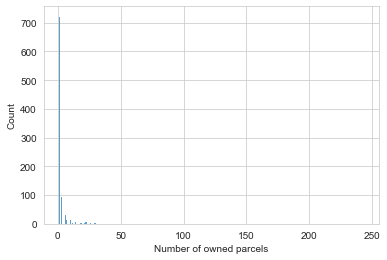

In [4]:
ax = sns.histplot(data=counts)
_ = ax.set(xlabel="Number of owned parcels")

* Obviously most owners own 1 parcel. Many 2 or 3. Curve flattens quickly afterwards.

### Zooming in: histogram & cumulative distribution

The following histogram starts with 2 parcels. The red line shows the cumulative distribution.

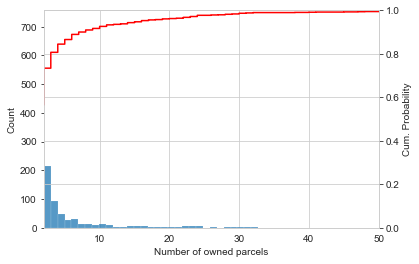

In [5]:
fig, ax = plt.subplots()
sns.histplot(data=counts, ax=ax, bins=max(counts) + 1)
ax.set(xlabel="Number of owned parcels")
ax.set(xlim=(2, 50))
ax.grid(False, axis="y")
ax2 = ax.twinx()
sns.ecdfplot(data=counts, ax=ax2, color="red")
ax2.set(xlim=(2, 50))
ax2.set(ylabel="Cum. Probability")
_ = plt.locator_params(axis="x", integer=True, tight=True)

* Owning > ~5 parcels brings you to the top decile of owners.

## Distribution of ownership

How well distributed is parcel ownership? I.e., is a large number of parcels in the hands of only a few?

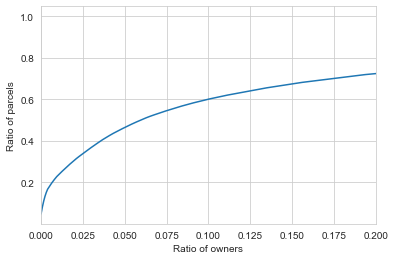

In [6]:
# What ratio of parcels does each owner own:
parcel_ratios = [c/parcels.shape[0] for o, c in sorted(parcels_per_owner.items(), key=lambda x: x[1], reverse=True)]
# Cumulated:
cumulated_parcel_ratios = [ sum(parcel_ratios[:i+1]) for i, r in enumerate(parcel_ratios)]
# Cumulated owner ratios:
cumulated_owner_ratios = [x/len(parcel_ratios) for x in range(len(parcel_ratios))]
# Plot:
ax = sns.lineplot(x=cumulated_owner_ratios, y=cumulated_parcel_ratios)
ax.set(xlabel="Ratio of owners")
ax.set(ylabel="Ratio of parcels")
_ = ax.set(xlim=(0, 0.2))

* 10% of the owners own 60% of all parcels.
* ~6% of the owners own half of all the parcels.

## Collaborators

In [7]:
collaborators = Counter([cleanc for p in parcels.contributors for c in (p or []) for cleanc in c.strip().split(" ") if cleanc != ""])
collaborator_counts = list(collaborators.values())
print("{} collaborators total".format(len(collaborators)))
print("Collaborations: {} min, {} max".format(sorted(collaborator_counts)[0], sorted(collaborator_counts)[-1]))


1439 collaborators total
Collaborations: 1 min, 70 max


## Collaborators leaderboard

In [8]:
show_leaderboard(collaborators, "collaborations")

## Owner-collaborators

How many owners are also collaborators?

In [9]:
len(set(parcels_per_owner.keys()) & set(collaborators.keys()))

235

## Parcel whales per island

I.e., who owns most of which island?

In [10]:
parcelwhales = (
    parcels.groupby(["island", "owner"])["id"]
    .agg("count")
    .groupby("island", group_keys=False)
    .nlargest(1)
    .to_frame()
    .reset_index("owner")
    .rename(columns={"id": "whaleparcels", "owner": "whale"})
    .merge(island_sizes["parcels"], left_on="island", right_on="island")
)
parcelwhales["whalecoverage"] = parcelwhales.whaleparcels / parcelwhales.parcels * 100
parcelwhales.drop(["Test Island", "Little Ceres"]).sort_values(
    "whalecoverage", ascending=False
)

,whale,whaleparcels,parcels,whalecoverage
island,,,,
Electron,0x9f0574a5f28779a1a682cfe4bbd090ee058d07aa,14,33,42.424242
Vibes,0x2d891ed45c4c3eab978513df4b92a35cf131d2e2,54,194,27.835052
Far Far Away,0x8115afd8dffce5579381ad27524b6feeae917bef,13,62,20.967742
Neutron,0x7c00c9f0e7aed440c0c730a9bd9ee4f49de20d5c,24,120,20.000000
Trinity,0xa752caf7592062ad2a162cbe437a5e7955f595ca,12,71,16.901408
Euro,0x6d54ce2652a9a544b97352ff711a0598169b989f,10,60,16.666667
Proton,0x7c00c9f0e7aed440c0c730a9bd9ee4f49de20d5c,19,120,15.833333
Tokyo,0x7c00c9f0e7aed440c0c730a9bd9ee4f49de20d5c,34,230,14.782609
The Bronx,0xfad0ea578c6c63fe495dc0ef9cf73fc2c69e1f47,10,86,11.627907


* Vibes is a younger island, so it makes sense that bnolan has most coverage there.